In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np

class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InitialBlock, self).__init__()

        self.main_branch = nn.Conv2d(in_channels, out_channels - 3, kernel_size = 3, stride = 2, padding = 1, bias = False)
        self.ext_branch = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.out_relu = nn.PReLU() 

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        out = torch.cat((main, ext), 1)
        out = self.bn(out)

        return self.out_relu(out)

class DownSamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, internal_ratio = 4, dropout_prob = 0):
        super(DownSamplingBottleneck, self).__init__()

        internal_channels = in_channels // internal_ratio

        self.main_max1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1, return_indices = True)
        
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, internal_channels, kernel_size = 2, stride = 2, bias = False),
            nn.BatchNorm2d(internal_channels),
            nn.PReLU()
        )
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(internal_channels, internal_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(internal_channels),
            nn.PReLU()
        )
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(internal_channels, out_channels, kernel_size= 1, stride= 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

        self.ext_regul = nn.Dropout2d(p = dropout_prob)

        self.out_relu = nn.PReLU()
    
    def forward(self, x):
        main, max_indices = self.main_max1(x)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h , w)

        if main.is_cuda:
            padding = padding.cuda()

        main = torch.cat((main, padding), 1)

        out = main + ext

        return self.out_relu(out), max_indices

class RegularBottleneck(nn.Module):
    def __init__(self, channels, internal_ratio = 4, kernel_size = 3, padding = 0, dilation = 1, dropout_prob = 0, asymmetric = False):
        super(RegularBottleneck, self).__init__()

        internal_channels = channels // internal_ratio

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(channels, internal_channels, kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(internal_channels),
            nn.PReLU()
        )
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, kernel_size = (kernel_size, 1), stride = 1, padding = (padding, 0), dilation = dilation, bias = False),
                nn.BatchNorm2d(internal_channels),
                nn.PReLU(),
                nn.Conv2d(internal_channels, internal_channels, kernel_size = (1, kernel_size), stride = 1, padding = (0, padding), dilation = dilation, bias = False),
                nn.BatchNorm2d(internal_channels),
                nn.PReLU()
            )
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, kernel_size = kernel_size, stride = 1, padding = padding, dilation = dilation, bias = False),
                nn.BatchNorm2d(internal_channels),
                nn.PReLU()
            )

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(internal_channels, channels, kernel_size = 1, stride= 1, bias = False),
            nn.BatchNorm2d(channels),
            nn.PReLU()
        )

        self.ext_regul = nn.Dropout2d(p = dropout_prob)

        self.out_relu = nn.PReLU()
    
    def forward(self, x):
        main = x

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_relu(out)

class UpsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, internal_ratio = 4, dropout_prob = 0):
        super(UpsamplingBottleneck, self).__init__()

        internal_channels = in_channels // internal_ratio

        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

        self.main_unpool1 = nn.MaxUnpool2d(kernel_size = 2)

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, internal_channels, kernel_size= 1, bias = False),
            nn.BatchNorm2d(internal_channels),
            nn.PReLU()
        )

        self.ext_conv2 = nn.Sequential(
            nn.ConvTranspose2d(internal_channels, internal_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False),
            nn.BatchNorm2d(internal_channels),
            nn.PReLU()
        )

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(internal_channels, out_channels, kernel_size= 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

        self.ext_regul = nn.Dropout2d(p = dropout_prob)

        self.out_relu = nn.PReLU()
    
    def forward(self, x, max_indices):
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_relu(out)

class LaneNet(nn.Module):
    def __init__(self):
        super(LaneNet, self).__init__()
    
        # Stage 0 - Initial Block
        self.initial_block = InitialBlock(3, 16)

        # Stage 1 - Shared Encoder
        self.downsample1_0 = DownSamplingBottleneck(16 ,64, dropout_prob = 0.01)
        self.regular1_1 = RegularBottleneck(64, padding = 1, dropout_prob = 0.01)
        self.regular1_2 = RegularBottleneck(64, padding = 1, dropout_prob = 0.01)
        self.regular1_3 = RegularBottleneck(64, padding = 1, dropout_prob = 0.01)
        self.regular1_4 = RegularBottleneck(64, padding = 1, dropout_prob = 0.01)

        # Stage 2 - Shared Encoder
        self.downsample2_0 = DownSamplingBottleneck(64, 128, dropout_prob = 0.1)
        self.regular2_1 = RegularBottleneck(128, padding = 1, dropout_prob = 0.1)
        self.dilated2_2 = RegularBottleneck(128, dilation = 2, padding = 2, dropout_prob = 0.1)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.1)
        self.dilated2_4 = RegularBottleneck(128, dilation = 4, padding = 4, dropout_prob = 0.1)
        self.regular2_5 = RegularBottleneck(128, padding = 1, dropout_prob = 0.1)
        self.dilated2_6 = RegularBottleneck(128, dilation = 8, padding = 8, dropout_prob = 0.1)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.1)
        self.dilated2_8 = RegularBottleneck(128, dilation = 16, padding = 16, dropout_prob =0.1)

        # Stage 3 - Encoder
        self.segmentation_regular3_0 = RegularBottleneck(128, padding = 1, dropout_prob = 0.05)
        self.cluster_regular3_0 = RegularBottleneck(128, padding = 1, dropout_prob = 0.05)

        self.segmentation_dilated3_1 = RegularBottleneck(128, dilation = 2, padding = 2, dropout_prob = 0.05)
        self.cluster_dilated3_1 = RegularBottleneck(128, dilation = 2, padding = 2, dropout_prob = 0.05)

        self.segmentation_asymmetric3_2 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.05)
        self.cluster_asymmetric3_2 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.05)

        self.segmentation_dilated3_3 = RegularBottleneck(128, dilation = 4, padding = 4, dropout_prob = 0.05)
        self.cluster_dilated3_3 = RegularBottleneck(128, dilation = 4, padding = 4, dropout_prob = 0.05)

        self.segmentation_regular3_4 = RegularBottleneck(128, padding = 1, dropout_prob = 0.05)
        self.cluster_regular3_4 = RegularBottleneck(128, padding = 1, dropout_prob = 0.05)

        self.segmentation_dilated3_5 = RegularBottleneck(128, dilation = 8, padding = 8, dropout_prob = 0.05)
        self.cluster_dilated3_5 = RegularBottleneck(128, dilation = 8, padding = 8, dropout_prob = 0.05)

        self.segmentation_asymmetric3_6 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.05)
        self.cluster_asymmetric3_6 = RegularBottleneck(128, kernel_size = 5, padding = 2, asymmetric = True, dropout_prob = 0.05)

        self.segmentation_dilated3_7 = RegularBottleneck(128, dilation = 16, padding = 16, dropout_prob = 0.05)
        self.cluster_dilated3_7 = RegularBottleneck(128, dilation = 16, padding = 16, dropout_prob = 0.05)

        # Stage 4 - Decoder
        self.segmentation_upsample4_0 = UpsamplingBottleneck(128, 64, dropout_prob = 0.05)
        self.cluster_upsample4_0 = UpsamplingBottleneck(128, 64, dropout_prob = 0.05)

        self.segmentation_regular4_1 = RegularBottleneck(64, padding = 1, dropout_prob = 0.05)
        self.cluster_regular4_1 = RegularBottleneck(64, padding = 1, dropout_prob = 0.05)

        self.segmentation_regular4_2 = RegularBottleneck(64, padding = 1, dropout_prob = 0.05)
        self.cluster_regular4_2 = RegularBottleneck(64, padding = 1, dropout_prob = 0.05)
        
        # Stage 5 - Decoder
        self.segmentation_upsample5_0 = UpsamplingBottleneck(64, 16, dropout_prob = 0.05)
        self.cluster_upsample5_0 = UpsamplingBottleneck(64, 16, dropout_prob = 0.05)

        self.segmentation_regular5_1 = RegularBottleneck(16, padding = 1, dropout_prob = 0.05)
        self.cluster_regular5_1 = RegularBottleneck(16, padding =1, dropout_prob = 0.05)

        self.segmentation_transposed_conv = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False)
        self.cluster_transposed_conv = nn.ConvTranspose2d(16, 5, kernel_size = 3, stride = 2, padding =1, output_padding = 1, bias = False)
    
    def forward(self, x):
        # Stage 0 - Initial Block
        x = self.initial_block(x)

        # Stage 1 - Shared Encoder
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Shared Encoder
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        seg = self.segmentation_regular3_0(x)
        seg = self.segmentation_dilated3_1(seg)
        seg = self.segmentation_asymmetric3_2(seg)
        seg = self.segmentation_dilated3_3(seg)
        seg = self.segmentation_regular3_4(seg)
        seg = self.segmentation_dilated3_5(seg)
        seg = self.segmentation_asymmetric3_6(seg)
        seg = self.segmentation_dilated3_7(seg)

        cluster = self.cluster_regular3_0(x)
        cluster = self.cluster_dilated3_1(cluster)
        cluster = self.cluster_asymmetric3_2(cluster)
        cluster = self.cluster_dilated3_3(cluster)
        cluster = self.cluster_regular3_4(cluster)
        cluster = self.cluster_dilated3_5(cluster)
        cluster = self.cluster_asymmetric3_6(cluster)
        cluster = self.cluster_dilated3_7(cluster)

        # Stage 4 - Decoder
        seg = self.segmentation_upsample4_0(seg, max_indices2_0)
        seg = self.segmentation_regular4_1(seg)
        seg = self.segmentation_regular4_2(seg)

        cluster = self.cluster_upsample4_0(cluster, max_indices2_0)
        cluster = self.cluster_regular4_1(cluster)
        cluster = self.cluster_regular4_2(cluster)

        # Stage 5 - Decoder
        seg = self.segmentation_upsample5_0(seg, max_indices1_0)
        seg = self.segmentation_regular5_1(seg)
        seg = self.segmentation_transposed_conv(seg)

        cluster = self.cluster_upsample5_0(cluster, max_indices1_0)
        cluster = self.cluster_regular5_1(cluster)
        cluster = self.cluster_transposed_conv(cluster)

        pix_embedding = F.relu(cluster)
        binary_seg_ret = torch.sigmoid(seg)
        
        #out = torch.cat((pix_embedding, binary_seg_ret), dim = 1)
        
        return pix_embedding, binary_seg_ret
        

In [9]:
from torchviz import make_dot

x = torch.zeros(1, 3, 640, 640, dtype=torch.float, requires_grad=False)
model = LaneNet()
y = model.cpu()(x)
vis_graph = make_dot(y, params=dict(list(model.named_parameters())))

In [10]:
from torchvision import models
from torchsummary import summary

model = LaneNet()
summary(model, (3, 640, 640), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 13, 320, 320]             351
         MaxPool2d-2          [-1, 3, 320, 320]               0
       BatchNorm2d-3         [-1, 16, 320, 320]              32
             PReLU-4         [-1, 16, 320, 320]               1
      InitialBlock-5         [-1, 16, 320, 320]               0
         MaxPool2d-6  [[-1, 16, 160, 160], [-1, 16, 160, 160]]               0
            Conv2d-7          [-1, 4, 160, 160]             256
       BatchNorm2d-8          [-1, 4, 160, 160]               8
             PReLU-9          [-1, 4, 160, 160]               1
           Conv2d-10          [-1, 4, 160, 160]             144
      BatchNorm2d-11          [-1, 4, 160, 160]               8
            PReLU-12          [-1, 4, 160, 160]               1
           Conv2d-13         [-1, 64, 160, 160]             256
      BatchNorm2d-14    

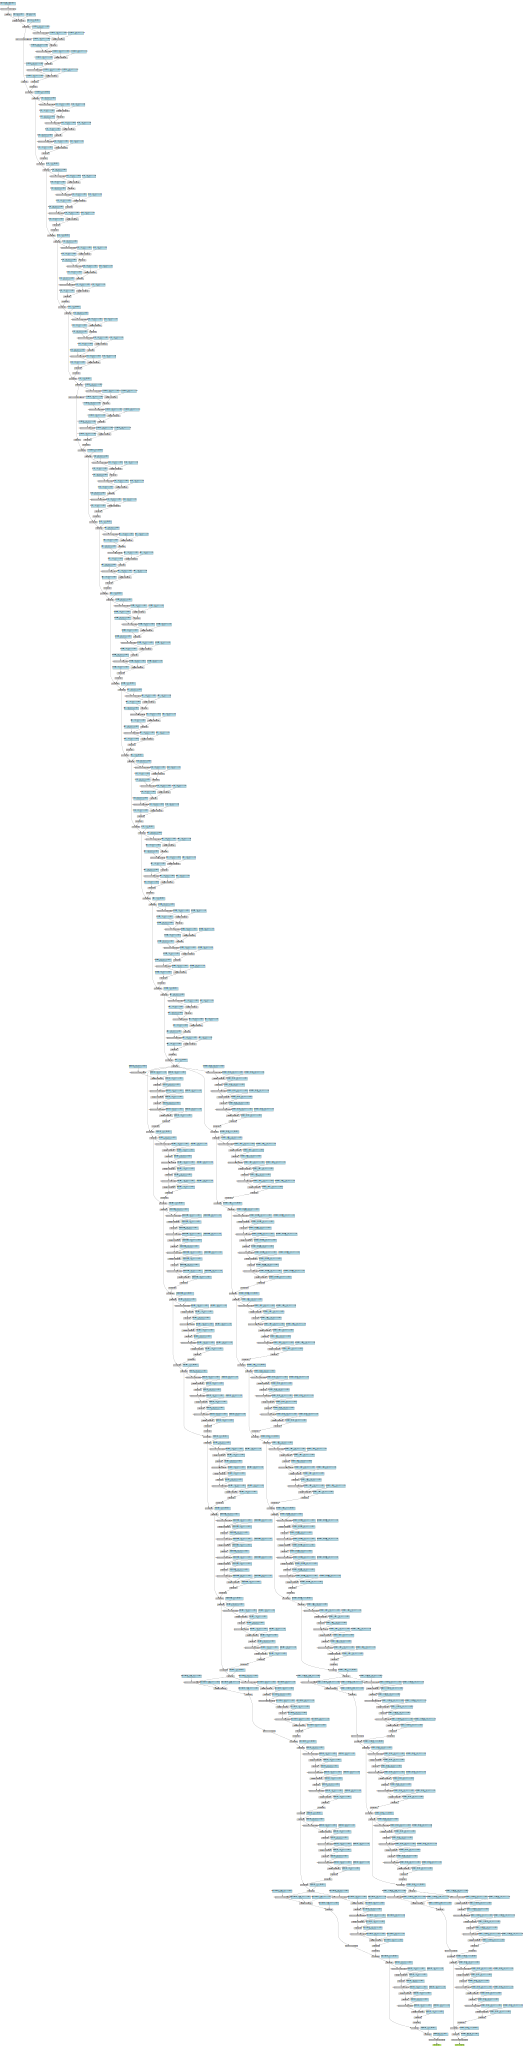

In [11]:
vis_graph